# 📈 K-Nearest Neighbors Regression

In this notebook, we explore K-Nearest Neighbors regression with:

- **Synthetic data** generated with Gaussian noise
- **SKLearn**'s built-in `KNeighborsClassifier`
- Implementing a custom **classic k-NN**
- Implementing a **weighted k-NN with Gaussian kernel**
  
Evaluation metrics and visualizations are included for comparison.

In [200]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from colorama import Fore, Style
from numpy.typing import NDArray
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

## 🛠️ Utils

In [201]:
def evaluate_regression(
    y_true: NDArray[np.float64], y_pred: NDArray[np.float64]
) -> dict[str, float]:
    """Compute and print regression evaluation metrics.

    Args:
        y_true (NDArray[np.float64]): True target values.
        y_pred (NDArray[np.float64]): Predicted target values.

    Returns:
        dict[str, float]: MAE, MSE, and R² score.
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{Fore.CYAN}Mean Absolute Error (MAE):{Style.RESET_ALL} {mae:.4f}")
    print(f"{Fore.CYAN}Mean Squared Error (MSE):{Style.RESET_ALL} {mse:.4f}")
    print(f"{Fore.CYAN}R² Score:{Style.RESET_ALL} {r2:.4f}")

    return {"mae": mae, "mse": mse, "r2": r2}

In [202]:
def plot_regression_results(
    x: NDArray[np.float64],
    y: NDArray[np.float64],
    X_test: NDArray[np.float64],
    y_pred: NDArray[np.float64],
    w: float,
    b: float,
    title: str = "Regression Plot",
) -> None:
    """Plot noisy data points, model predictions, and the original regression line.

    Args:
        x (NDArray[np.float64]): Full input features used to generate noisy data.
        y (NDArray[np.float64]): Noisy target values.
        X_test (NDArray[np.float64]): Test feature values used for predictions.
        y_pred (NDArray[np.float64]): Predicted values from the regression model.
        w (float): True slope of the underlying model (for reference line).
        b (float): True intercept of the underlying model.
        title (str): Title of the plot. Default is "Regression Plot".
    """
    x_range = np.linspace(min(x), max(x), 100).reshape(-1, 1)
    y_line = b + x_range * w

    sns.scatterplot(x=x.flatten(), y=y.flatten(), alpha=0.3, label="Noisy data points")
    sns.lineplot(
        x=X_test.flatten(),
        y=y_pred.flatten(),
        color="red",
        label="Regression line (prediction)",
    )
    sns.lineplot(
        x=x_range.flatten(),
        y=y_line.flatten(),
        color="green",
        label="Original regression line (no noise)",
    )
    plt.title(title)
    plt.legend()
    plt.show()

---

In [203]:
def minkowski_metric(
    X_train: NDArray[np.float64], x_new: NDArray[np.float64], p: float = 2.0
) -> NDArray[np.float64]:
    """Compute the Minkowski distance between two points.

    Args:
        X_train (NDArray): Training samples, shape (n_samples, n_features).
        x_new (NDArray): Single test sample, shape (n_features,).
        p (float, optional): Order of the Minkowski distance (default 2 = Euclidean).

    Returns:
        NDArray: Distances from x_new to each sample in X_train.
    """
    return np.sum(np.abs(X_train - x_new) ** p, axis=1) ** (1 / p)

## 📊 Generate Dataset

In [204]:
def generate_data(
    n: int, w: float, b: float, noise_level: float = 1.0, seed: int = 42
) -> tuple[NDArray[np.float64], NDArray[np.float64]]:
    """Generate synthetic linear data with Gaussian noise.

    Args:
        n (int): Number of data points to generate.
        w (float): Slope of the linear function.
        b (float): Intercept of the linear function.
        noise_level (float): Standard deviation of Gaussian noise added to the data.
        seed (int): Seed for the random number generator.

    Returns:
        tuple[NDArray[np.float64], NDArray[np.float64]]: Tuple containing the list of x
        values and corresponding noisy y values.
    """
    rng = np.random.default_rng(seed)
    x = rng.uniform(0, 25, n)
    y = w * x + b + rng.normal(0, noise_level, n)
    return x, y


# Set true parameters of the linear relationship
w = 2.5  # Slope coefficient
b = 1.5  # Intercept (bias term)

# Generate dataset
x, y = generate_data(n=1000, w=w, b=b, noise_level=4.5)

In [205]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# Convert lists to numpy arrays with correct shape for sklearn
X_train_np = np.array(X_train).reshape(-1, 1)
X_test_np = np.array(X_test).reshape(-1, 1)

## ⚙️ SKLearn Model

In [206]:
# Create and train the model
model = KNeighborsRegressor(n_neighbors=5, algorithm="brute", metric="minkowski")
model.fit(X_train_np, y_train)

# Predict on test data
predicted = model.predict(X_test_np)

In [207]:
_ = evaluate_regression(y_test, predicted)

Mean Absolute Error (MAE): 4.0414
Mean Squared Error (MSE): 26.3348
R² Score: 0.9298


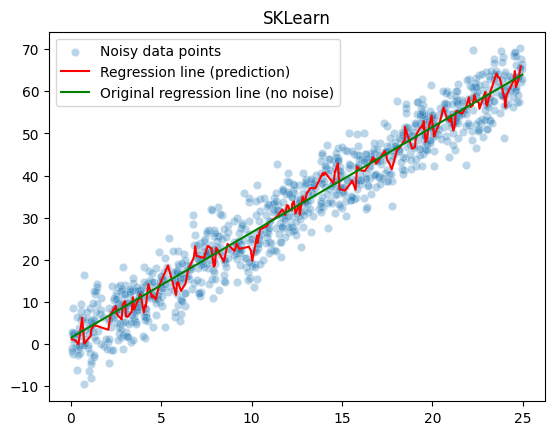

In [208]:
plot_regression_results(x, y, X_test, predicted, w, b, "SKLearn")

## 🧪 Custom Implementations

### 🏘 K-nearest neighbors regression

In [209]:
def knn_regression_predict(
    X_train: NDArray[np.float64],
    y_train: NDArray[np.int64],
    x_new: NDArray[np.float64],
    k_neighbors: int = 3,
    p: float = 2.0,
) -> float:
    """Predict the label for a new data point using k-NN regression.

    Args:
        X_train (NDArray[np.float64]): Training features, shape (n_samples, n_features).
        y_train (NDArray[np.int64]): Training labels, shape (n_samples,).
        x_new (NDArray[np.float64]): Single test sample, shape (n_features,).
        k_neighbors (int, optional): Number of neighbors to use. Defaults to 3.
        p (float, optional): Minkowski distance order. Defaults to 2.0.

    Returns:
        float: Predicted label for x_new based on the mean of nearest neighbors.
    """
    distances = minkowski_metric(X_train, x_new, p)

    neighbors_idx = distances.argsort()[:k_neighbors]
    neighbor_labels = y_train[neighbors_idx]

    mean_label = np.mean(neighbor_labels)

    return mean_label


# Predict labels for all samples in X_test
predicted = np.array(
    [
        knn_regression_predict(X_train_np, y_train, x_new, k_neighbors=5, p=4)
        for x_new in X_test_np
    ]
)

In [210]:
_ = evaluate_regression(y_test, predicted)

Mean Absolute Error (MAE): 4.0414
Mean Squared Error (MSE): 26.3348
R² Score: 0.9298


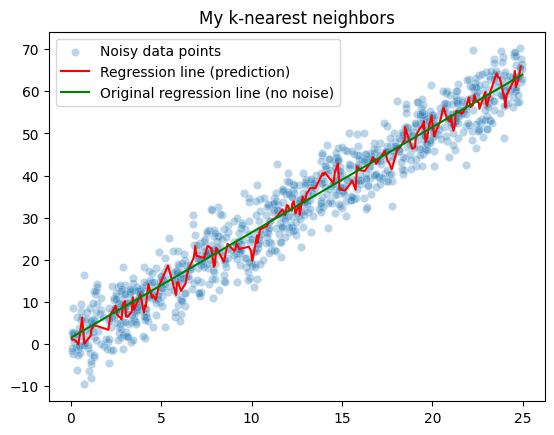

In [211]:
plot_regression_results(x, y, X_test, predicted, w, b, "My k-nearest neighbors")

### ⚖️ Weighted k-nearest neighbors regression

In [212]:
def gaussian_kernel(t: NDArray[np.float64] | float) -> NDArray[np.float64] | float:
    """Gaussian (normal) kernel function.

    Args:
        t (NDArray[np.float64] | float): Input value(s).

    Returns:
        NDArray[np.float64] | float: Kernel-weighted value(s).
    """
    return np.exp(-(t**2) / 2) / np.sqrt(2 * np.pi)


def weighted_knn_regression_kernel(
    X_train: NDArray[np.float64],
    y_train: NDArray[np.int64],
    X_test: NDArray[np.float64],
    k_neighbors: int = 3,
    p: float = 2.0,
    h: float = 1.0,
) -> NDArray[np.float64]:
    """Predict labels using weighted k-NN regression with a Gaussian kernel.

    Args:
        X_train (NDArray[np.float64]): Training features, shape (n_samples, n_features).
        y_train (NDArray[np.int64]): Training labels, shape (n_samples,).
        X_test (NDArray[np.float64]): Test features, shape (n_test_samples, n_features).
        k_neighbors (int, optional): Number of neighbors to consider. Defaults to 3.
        p (float, optional): Order of the Minkowski distance. Defaults to 2.0.
        h (float, optional): Bandwidth parameter for the Gaussian kernel. Defaults to 1.

    Returns:
        NDArray[np.float64]: Predicted labels for each sample in X_test.
    """
    y_predicted: list[float] = []

    for x_new in X_test:
        distances = minkowski_metric(X_train, x_new, p)

        neighbors_idx = distances.argsort()[:k_neighbors]
        neighbor_labels = y_train[neighbors_idx].astype(np.float64)
        neighbor_distances = distances[neighbors_idx]

        weights = gaussian_kernel(neighbor_distances / h)

        weighted_sum = np.sum(weights * neighbor_labels)
        weight_total = np.sum(weights)

        predicted_label = (
            weighted_sum / weight_total if weight_total != 0 else np.mean(y_train)
        )
        y_predicted.append(predicted_label)

    return np.array(y_predicted)


# Predict labels for all samples in X_test
predicted = weighted_knn_regression_kernel(
    X_train_np, y_train, X_test_np, k_neighbors=5, p=5, h=0.5
)

In [213]:
_ = evaluate_regression(y_test, predicted)

Mean Absolute Error (MAE): 4.0426
Mean Squared Error (MSE): 26.3430
R² Score: 0.9298


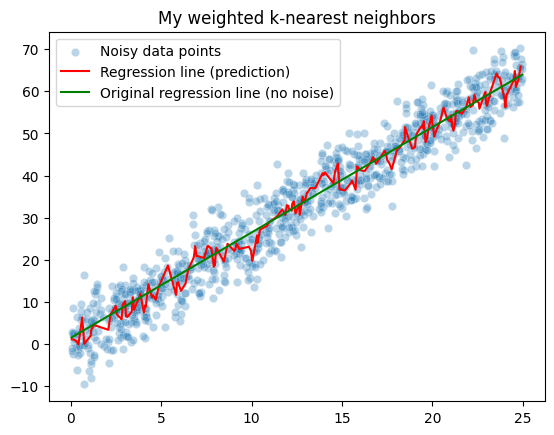

In [214]:
plot_regression_results(
    x, y, X_test, predicted, w, b, "My weighted k-nearest neighbors"
)